In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
heart_df = pd.read_csv("heart_cleveland_upload.csv")
heart_df = heart_df.rename(columns={'condition': 'target'}) if 'condition' in heart_df.columns else heart_df

X = heart_df.drop(columns='target')
y = heart_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
def tune_model(name, model, param_grid):
    print(f"🔍 Tuning {name}...")
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

In [6]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': tune_model('Random Forest', RandomForestClassifier(), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10]
    }),
    'SVM': tune_model('SVM', SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': tune_model('XGBoost', XGBClassifier(eval_metric='logloss'), {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    })
}

🔍 Tuning Random Forest...
🔍 Tuning SVM...
🔍 Tuning XGBoost...


In [7]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': cm
    })

In [8]:
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print("\n📊 Model Performance Comparison:\n")
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].to_string(index=False))


📊 Model Performance Comparison:

              Model  Accuracy  Precision  Recall  F1 Score
            XGBoost  0.988327   1.000000   0.976  0.987854
      Random Forest  0.976654   1.000000   0.952  0.975410
      Decision Tree  0.976654   1.000000   0.952  0.975410
                SVM  0.968872   0.983471   0.952  0.967480
                KNN  0.817121   0.791045   0.848  0.818533
Logistic Regression  0.789883   0.748252   0.856  0.798507


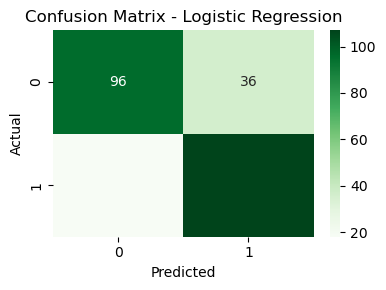

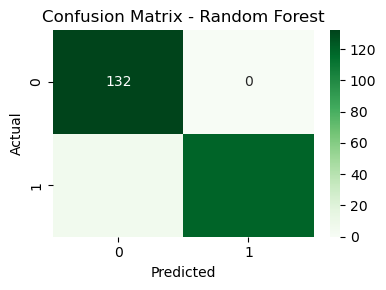

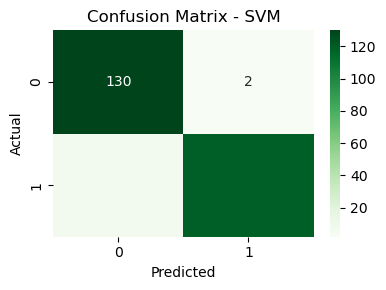

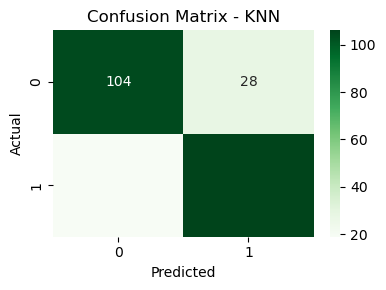

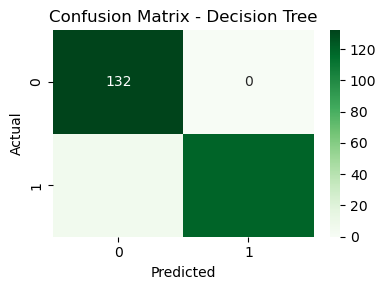

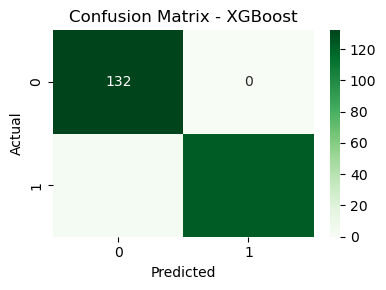

In [9]:
for result in results:
    plt.figure(figsize=(4, 3))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix - {result['Model']}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [10]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
pickle.dump(best_model, open("best_heart_model.pkl", 'wb'))
pickle.dump(scaler, open("scaler.pkl", 'wb'))

print(f"\n✅ Best Model: {best_model_name} (F1 Score: {results_df.iloc[0]['F1 Score']:.4f}) saved successfully.")


✅ Best Model: XGBoost (F1 Score: 0.9879) saved successfully.


In [11]:
y_pred = best_model.predict(X_test_scaled)

In [12]:
unique, counts = np.unique(y_pred, return_counts=True)
prediction_distribution = dict(zip(unique, counts))

print("🔍 Prediction distribution on test data:", prediction_distribution)

🔍 Prediction distribution on test data: {0: 135, 1: 122}
